In [1]:
import pandas as pd
from matplotlib import pyplot, dates
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller

In [2]:
path_train = './New_train_data.csv'
train = pd.read_csv(path_train)

In [3]:
train

,DateTime,X1,X2,X3,X4,Y
0,2021/12/31 23:00,2.186333,13.76,0.0663,0.1547,5.211638e+05
1,2022/01/01 0:00,12.087667,84.86,0.4914,0.7410,2.494531e+06
2,2022/01/01 1:00,10.903667,87.28,0.4719,0.8775,2.117415e+06
3,2022/01/01 2:00,10.145333,88.58,0.4862,1.0231,1.873545e+06
4,2022/01/01 3:00,9.870000,86.06,0.4381,1.1336,1.766122e+06
...,...,...,...,...,...,...
6985,2022/10/19 0:00,35.403333,105.24,0.6188,0.8281,2.454735e+06
6986,2022/10/19 1:00,34.956667,105.42,0.4901,0.9243,2.323497e+06
6987,2022/10/19 2:00,34.866667,105.70,0.6019,0.8957,2.241004e+06
6988,2022/10/19 3:00,35.326667,105.88,0.6591,0.9802,2.206828e+06


### Data Prepartion

In [4]:
# parsing to datetime
train.DateTime = pd.to_datetime(train.DateTime)

In [5]:
train.dtypes

DateTime    datetime64[ns]
X1                 float64
X2                 float64
X3                 float64
X4                 float64
Y                  float64
dtype: object

In [6]:
#train['DateTime'] = train['DateTime'].dt.to_period('s')

In [7]:
train.set_index(train['DateTime'],inplace=True)

In [8]:
# DateTime changed into the index
train_idx = train[['X1', 'X2', 'X3', 'X4', 'Y']]

In [9]:
# Extracting only Y
train_w_y = train_idx[['Y']]

### Autocorrelation plot

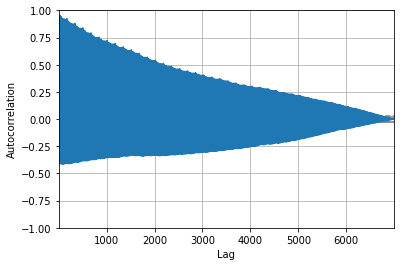

In [10]:
autocorrelation_plot(train_w_y)

ADF stat:  -5.159608702792071
P-value:  1.0624408341986296e-05


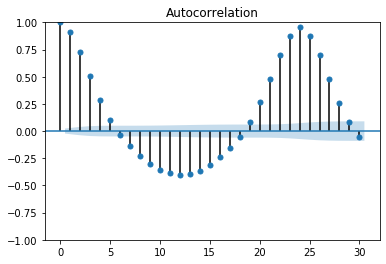

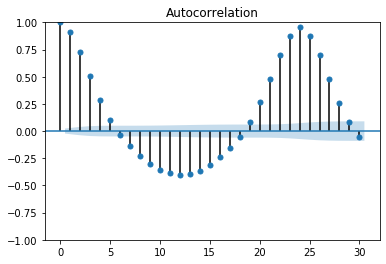

In [46]:
# Limiting the x-axis to have a closer look
stationarityTest = adfuller(train_w_y, autolag='AIC')
print("ADF stat: ", stationarityTest[0])
print("P-value: ", stationarityTest[1])
plot_acf(train_w_y, lags=30)

The p-value of 0.0 is obtained which is < 0.05, and the ADF stat value is around -31.76. This means we should reject the null hypothesis, which indicates that the time series is non-stationary and has time dependent structure.
The 'p' parameter of ARIMA model should be 5 accordinng to the AutoCorrelation plot.

### AutoRegressive Model

In [35]:
X = train_w_y.values
l = int(len(X)*0.5)
strain = X[:l]
stest = X[l:]

In [53]:
ar_model = AutoReg(strain, lags = 5).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 3495
Model:                     AutoReg(5)   Log Likelihood              -47662.128
Method:               Conditional MLE   S.D. of innovations         206453.768
Date:                Sat, 29 Jan 2022   AIC                          95338.257
Time:                        15:04:35   BIC                          95381.360
Sample:                             5   HQIC                         95353.642
                                 3495                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.357e+05   1.97e+04     22.167      0.000    3.97e+05    4.74e+05
y.L1           1.5560      0.017     91.926      0.000       1.523       1.589
y.L2          -0.7388      0.031    -23.601      0.0

[[3.11047593e+07 1.33800122e+10 6.60087343e+10 ... 2.44635196e+11
  2.44635196e+11 2.44635196e+11]
 [5.02073770e+09 2.53935392e+09 3.67265221e+10 ... 1.84320902e+11
  1.84320902e+11 1.84320902e+11]
 [6.61697178e+09 1.59236078e+09 3.28167874e+10 ... 1.75425685e+11
  1.75425685e+11 1.75425685e+11]
 ...
 [1.21350802e+12 9.61074820e+11 7.04079727e+11 ... 3.61694151e+11
  3.61694151e+11 3.61694151e+11]
 [1.28997118e+12 1.02925046e+12 7.62600786e+11 ... 4.03969202e+11
  4.03969202e+11 4.03969202e+11]
 [4.92200859e+12 4.39871284e+12 3.82617546e+12 ... 2.95281869e+12
  2.95281869e+12 2.95281869e+12]]


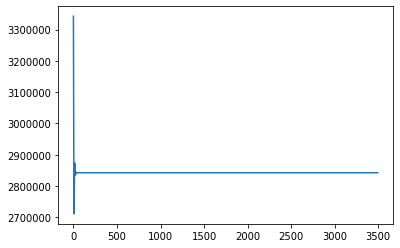

In [54]:
# Predictions
pred = ar_model.predict(start = len(strain), end = (len(train_w_y)-1), dynamic = False)
rmse = (pred-stest)**2
print(rmse)
#for i in range(len(pred)):
    #print(f'predicted={pred[i]}, expected={stest[i]}')
pyplot.plot(pred)
#pyplot.plot(stest, color = 'red')
pyplot.show()